# Classification Approach

- This notebook is inspired by [this thread](https://www.kaggle.com/competitions/playground-series-s4e4/discussion/491339). The goal is to evaluate the performance of classifiers and classifier ensembles for this competition.
- I've also tried to blend the results of this notebook with that of the [current top-ranking publicly available notebook](https://www.kaggle.com/code/arunklenin/ps4e4-prediction-generalization-regression) to see whether a classifier ensemble boosts its score.


In [1]:
import pandas as pd
import numpy as np
import optuna
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_SPLITS = 10
N_REPEATS = 5

# Loading and Processing Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv', index_col='id')

train['Sex'] = train['Sex'].map({'M': 0, 'F': 1, 'I': 2})
test['Sex'] = test['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = train.drop(columns='Rings')
y = train['Rings']

# Defining CV and Training Function
The function, `RMSLEOptimized`, is taken directly from [this topic](https://www.kaggle.com/competitions/playground-series-s4e4/discussion/491339) without any change. All credit goes therefore to the original author of the topic.

In [4]:
def RMSLEOptimized(base_classifier_class):
    class RMSLEOptimizedClassifier(base_classifier_class):
        def fit(self, X, y):
            enc = LabelEncoder().fit(y)
            self.c_ = np.log1p(enc.classes_)
            super().fit(X, enc.transform(y))
            return self

        def predict(self, X):
            return np.expm1(np.sum(super().predict_proba(X)*self.c_, axis=1))
    return RMSLEOptimizedClassifier

In [5]:
def train(model, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    oof_preds = np.zeros(len(X), dtype=float)
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        y_pred = np.zeros_like(y_val, dtype=float)
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(X_train, y_train)
            y_pred += m.predict(X_val)

        y_pred /= n_repeats
        y_pred = y_pred.clip(1, 29)

        score = np.sqrt(mean_squared_log_error(y_val, y_pred))
        scores.append(score)
        oof_preds[val_idx] = y_pred

    return scores, oof_preds


def predict(model, X, y, X_test, n_repeats=N_REPEATS):
    y_pred = np.zeros(len(X_test), dtype=float)
    for i in range(n_repeats):
        m = clone(model)
        if n_repeats > 1:
            m.set_params(random_state=i)
        m.fit(X, y)
        y_pred += m.predict(X_test)
    y_pred /= n_repeats
    y_pred = y_pred.clip(1, 29)
    return y_pred

# Tuning Hyperparameters with Optuna

In [6]:
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'random_state': SEED,
        'n_jobs': -1,
    }
    params['max_depth'] = trial.suggest_int('max_depth', 3, 9, step=2)
    params['min_child_weight'] = trial.suggest_int('min_child_weight', 2, 10)
    params['eta'] = trial.suggest_float('eta', 1e-8, 1.0, log=True)
    params['gamma'] = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    params['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)

    xgb_model = RMSLEOptimized(XGBClassifier)(**params)
    xgb_scores, _ = train(xgb_model, X, y, 5, 1)
    
    return np.mean(xgb_scores)

# xgb_study = optuna.create_study(direction='minimize', study_name='XGBoost')
# xgb_study.optimize(xgb_objective, n_trials=1000, n_jobs=-1)
# xgb_params = xgb_study.best_params

In [7]:
def cb_objective(trial):
    params = {
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 1, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'random_strength': trial.suggest_int('random_strength', 10, 100),
        'border_count': trial.suggest_int('border_count', 150, 300), 
        'random_state': SEED, 
        'verbose': False
    }
    cb_model = RMSLEOptimized(CatBoostClassifier)(**params)
    cb_scores, _ = train(cb_model, X, y, 5, 1)

    return np.mean(cb_scores)


# cb_study = optuna.create_study(direction='minimize', study_name='CatBoost')
# cb_study.optimize(cb_objective, n_trials=1000, n_jobs=-1, catch=(ValueError, RuntimeError))
# cb_params = cb_study.best_params

In [8]:
xgb_params = {
    'n_jobs': -1,
    'max_depth': 7,
    'n_estimators': 671,
    'random_state': SEED,
    'min_child_weight': 10,
    'eta': 1.0587175909624386e-08,
    'alpha': 0.0037647024033841104,
    'lambda': 1.611786509104389e-06,
    'gamma': 1.7477246190281184e-07,
    'subsample': 0.7729054495069687,
    'learning_rate': 0.06668333538114861,
    'colsample_bytree': 0.4328823966732981,
}

cb_params = {
    'depth': 9,
    'verbose': False,
    'iterations': 978,
    'random_state': SEED,
    'l2_leaf_reg': 2.225407966369204,
    'learning_rate': 0.42362856656186987,
    'colsample_bylevel': 0.09086110013571472,
}

# Training Base Models

In [9]:
xgb_model = RMSLEOptimized(XGBClassifier)(**xgb_params)
xgb_scores, xgb_oof_preds = train(xgb_model, X, y)
print(f'XGB:  {np.mean(xgb_scores)}')

cb_model = RMSLEOptimized(CatBoostClassifier)(**cb_params)
cb_scores, cb_oof_preds = train(cb_model, X, y)
print(f'CB:   {np.mean(cb_scores)}')

XGB:  0.1485796021839296
CB:   0.15023944800301678


# Training and Tuning a VotingClassifier

In [10]:
estimators = [
    ('XGB', xgb_model),
    ('CB', cb_model)
]

In [11]:
def ensemble_objective(trial):
    params = {
        'xgb_weight': trial.suggest_float('xgb_weight', 0.0, 1.0),
        'cb_weight': trial.suggest_float('cb_weight', 0.0, 1.0)
    }

    weights = [
        params['xgb_weight'],
        params['cb_weight']
    ]
    weights /= np.sum(weights)

    voter = RMSLEOptimized(VotingClassifier)(estimators=estimators, weights=weights, n_jobs=-1, voting='soft')
    scores, _ = train(voter, X, y, 5, 1)
    
    return np.mean(scores)

# ensemble_study = optuna.create_study(direction='minimize', study_name='Voter')
# ensemble_study.optimize(ensemble_objective, n_trials=2, timeout=30, n_jobs=-1)
# best_weights = ensemble_study.best_params

In [12]:
best_weights = {'xgb_weight': 0.8993242323514871, 'cb_weight': 0.2704695662720201}

weights = [
    best_weights['xgb_weight'],
    best_weights['cb_weight']
]

weights /= np.sum(weights)
print(f'\nBest Weights: {list(weights)}')


Best Weights: [0.7687886817400803, 0.2312113182599197]


In [13]:
voter = RMSLEOptimized(VotingClassifier)(estimators=estimators, weights=weights, n_jobs=-1, voting='soft')
voter_scores, oof_preds = train(voter, X, y, 10, 1)

print(f'Voter: {np.mean(voter_scores)}')

Voter: 0.14871297635216524


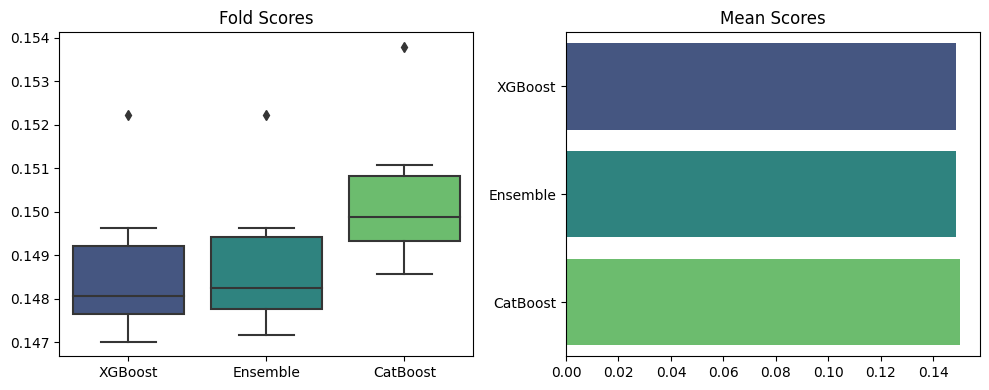

In [14]:
scores = pd.DataFrame({
    'XGBoost': xgb_scores,
    'CatBoost': cb_scores,
    'Ensemble': voter_scores
})
scores = scores[scores.mean().sort_values().index]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(data=scores, ax=axes[0], palette='viridis')
axes[0].set_title('Fold Scores')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
mean_scores = scores.mean().sort_values()
sns.barplot(x=mean_scores, y=mean_scores.index, orient='h', ax=axes[1], palette='viridis')
axes[1].set_title('Mean Scores')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim()
plt.tight_layout()
plt.show()

# Blending Results

In [15]:
y_preds = predict(voter, X, y, test, 1)
voter_sub = pd.DataFrame({'id': test.index, 'Rings': y_preds})
voter_sub.to_csv('xgb_cb_ensemble.csv', index=False)
voter_sub.head()

,id,Rings
0,90615,9.823694
1,90616,9.819738
2,90617,9.936741
3,90618,10.375321
4,90619,7.632145


In [16]:
public_lb_best_sub = pd.read_csv(f"/kaggle/input/ps4e4-prediction-generalization-regression/submission.csv")["Rings"].values
ensemble_sub = voter_sub["Rings"].values

submission = voter_sub.copy()
submission["Rings"] = np.average(np.c_[public_lb_best_sub, ensemble_sub], axis=1, weights=[0.85, 0.15])
submission["Rings"] = submission["Rings"].clip(1, 29)
submission["Rings"] = np.where(submission["Rings"].between(27.5, 29), 29, submission["Rings"])
submission.to_csv("xgb_cb_ensemble-public_lb_best.csv", index=None)
submission.head()

,id,Rings
0,90615,9.738878
1,90616,9.705969
2,90617,9.714260
3,90618,10.536998
4,90619,7.602535
